# 天猫订单综合分析

## 一、 数据介绍  
数据来源：https://www.kesci.com/mw/project/5eb60fd0366f4d002d7792d5/dataset  
本数据集共收集了发生在2020年2月1日至2020年2月29日一个月内的28010条数据，均来自天猫真实订单。  
字段说明：  
1. 订单编号：订单编号  
2. 总金额：订单总金额  
3. 买家实际支付金额：总金额 - 退款金额（在已付款的情况下）。金额为0（在未付款的情况下）  
4. 收货地址：各个省份  
5. 订单创建时间：下单时间  
6. 订单付款时间：付款时间  
7. 退款金额：付款后申请退款的金额。如无付过款，退款金额为0  

## 二、 分析目的  
1. 计算订单每个环节的转化转化率，得到漏斗图  
2. 绘制订单成交的时间（按天）趋势(按实际成交）  
3. 将订单数在地图上的分布

## 三、 数据预处理

In [275]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('qt4agg')
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('./data/tmall_order_report.csv',engine = 'python',encoding = 'utf')

In [276]:
df.head()

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
0,1,178.8,0.0,上海,2020-02-21 00:00:00,NaN,0.0
1,2,21.0,21.0,内蒙古自治区,2020-02-20 23:59:54,2020-02-21 00:00:02,0.0
2,3,37.0,0.0,安徽省,2020-02-20 23:59:35,NaN,0.0
3,4,157.0,157.0,湖南省,2020-02-20 23:58:34,2020-02-20 23:58:44,0.0
4,5,64.8,0.0,江苏省,2020-02-20 23:57:04,2020-02-20 23:57:11,64.8


In [277]:
df.tail()

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
28005,28006,37.0,37.0,四川省,2020-02-27 00:01:00,2020-02-27 00:01:10,0.0
28006,28007,69.0,0.0,上海,2020-02-27 00:00:18,NaN,0.0
28007,28008,69.0,0.0,上海,2020-02-27 00:00:17,NaN,0.0
28008,28009,37.0,37.0,辽宁省,2020-02-27 00:00:09,2020-02-27 00:00:17,0.0
28009,28010,37.0,37.0,广东省,2020-02-27 00:00:06,2020-02-27 00:00:11,0.0


### 1. 规范字段名称  
查看数据集字段名称发现，部分字段名称后有空格，为了方便后面的数据分析，因此需将空格删去。

In [278]:
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址 ', '订单创建时间', '订单付款时间 ', '退款金额'], dtype='object')

In [279]:
# 将字段名称中空格去掉，规范字段名称
df = df.rename( columns = {'收货地址 ':'收货地址','订单付款时间 ':'订单付款时间'} )
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址', '订单创建时间', '订单付款时间', '退款金额'], dtype='object')

### 2. 重复值处理

In [280]:
df.duplicated().sum()

0

由以上运行结果可知，本数据集并无重复值。

### 3. 缺失值处理

In [281]:
df.isnull().sum()
# 订单付款时间 有2923个缺失值，属于正常现象，说明这些单位付过款，无需处理

订单编号           0
总金额            0
买家实际支付金额       0
收货地址           0
订单创建时间         0
订单付款时间      3923
退款金额           0
dtype: int64

由以上运行结果可知，本数据集并无缺失值。

## 四、数据分析

### （一） 订单转化率  
### 1. 计算每个环节的数据  
整个订单的环节包括：用户下单->用户付款->卖家收款->卖家全额收款。

In [282]:
dict_convs = dict()

**（1） 订单总数**  
订单总数可用于表示用户下单这一环节。

In [283]:
key = '总订单数'

dict_convs[key] = len(df)
len(df)

28010

**（2） 付过款的订单数**  
只要付款时间不为零，则可表示该用户已付过款。因此付过款的订单数可用来表示用户付款这一环节。

In [284]:
key = '付款订单数'

# 付款时间不为空的，表示付过款
df_payed = df[df['订单付款时间'].notnull()]
dict_convs[key] = len(df_payed)

len(df_payed)

24087

**（3） 到款订单数**  
用户付款后也可能存在退款的情况，但是要买家实际付款不为零，则可表示卖家收到过款。因此到款订单数可用来表示卖家收款这一环节。

In [285]:
key = '到款订单数'

# 买家实际支付金额：总金额 - 退款金额（在已付款的情况下）
# 买家实际支付金额不为0的，说明订单商家收到过款
df_trans = df_payed[df_payed['买家实际支付金额'] != 0]
dict_convs[key] = len(df_trans)

len(df_trans)

18955

**（4） 全额到款订单数**  
用户付款后，只要退款金额为零，则表示用户全额付款，卖家已全额收款。因此全额到款订单数可用来表示卖家全额收款，此时整个订单的购买流程已完成。

In [286]:
key = '全额到款订单数'

# 在付款的订单中，退款金额为0的，说明没有退款，表示全额收款
df_trans_full = df_payed[df_payed['退款金额'] == 0]
dict_convs[key] = len(df_trans_full)

len(df_trans_full)

18441

整个订单各个环节的数据如下：

In [287]:
df_convs = pd.Series(dict_convs,name='订单数').to_frame()
df_convs

,订单数
总订单数,28010
付款订单数,24087
到款订单数,18955
全额到款订单数,18441


### 2. 计算转化率，绘制漏斗图  
**（1） 总体转化率**

In [288]:
# 添加总体转化率,每个环节除以总订单数
name = '总体转化率'
total_convs = df_convs['订单数']/df_convs.loc['总订单数','订单数']*100
df_convs[name] = total_convs.apply(lambda x : round(x,0))
df_convs

,订单数,总体转化率
总订单数,28010,100.0
付款订单数,24087,86.0
到款订单数,18955,68.0
全额到款订单数,18441,66.0


In [289]:
from pyecharts.charts import Funnel
from pyecharts import options as opts

In [290]:
name = '总体转化率'
funnel = Funnel().add(
                    series_name = name,
                    data_pair = [ list(z) for z in zip(df_convs.index,df_convs[name]) ],
                    is_selected = True,
                    label_opts = opts.LabelOpts(position = 'inside')
                    )
funnel.set_series_opts(tooltip_opts = opts.TooltipOpts(formatter = '{a}<br/>{b}:{c}%'))

funnel.set_global_opts( title_opts = opts.TitleOpts(title = name),
#                         tooltip_opts = opts.TooltipOpts(formatter = '{a}<br\>{b}:{c}%'),
                      )
                        
funnel.render_notebook()

**（2） 环节转化率**

In [291]:
# 添加环节转化率,每个环节除以上一个环节
# 添加单一环节转化率,每个环节除以上一环节

name = '单一环节转化率'
single_convs = df_convs['订单数'].shift()

df_convs[name] = single_convs.fillna(df_convs.loc['总订单数','订单数'])

# df_convs[name] = (df_convs['订单数']/df_convs[name]*100).apply(lambda x : round(x,0))

df_convs[name] = round((df_convs['订单数']/df_convs[name]*100),0)
df_convs

,订单数,总体转化率,单一环节转化率
总订单数,28010,100.0,100.0
付款订单数,24087,86.0,86.0
到款订单数,18955,68.0,79.0
全额到款订单数,18441,66.0,97.0


In [292]:
name = '单一环节转化率'

funnel = Funnel().add(
                    series_name = name,
                    data_pair = [ list(z) for z in zip(df_convs.index,df_convs[name]) ],
                    is_selected = True,
                    label_opts = opts.LabelOpts(position = 'inside')
                    )
funnel.set_series_opts(tooltip_opts = opts.TooltipOpts(formatter = '{a}<br/>{b}:{c}%'))

funnel.set_global_opts( title_opts = opts.TitleOpts(title = name),
#                         tooltip_opts = opts.TooltipOpts(formatter = '{a}<br\>{b}:{c}%'),
                      )
                        
funnel.render_notebook()

### （二） 整体订单趋势

### 1. 整体订单数趋势

In [293]:
from pyecharts.charts import Line

In [294]:
# 按到款订单统计
df_trans['订单创建时间'] = df_trans['订单创建时间'].astype('datetime64')
df_trans=df_trans.set_index('订单创建时间')
df_trans.head()

,订单编号,总金额,买家实际支付金额,收货地址,订单付款时间,退款金额
订单创建时间,,,,,,
2020-02-20 23:59:54,2,21.0,21.0,内蒙古自治区,2020-02-21 00:00:02,0.0
2020-02-20 23:58:34,4,157.0,157.0,湖南省,2020-02-20 23:58:44,0.0
2020-02-20 23:56:39,6,327.7,148.9,浙江省,2020-02-20 23:56:53,178.8
2020-02-20 23:56:36,7,357.0,357.0,天津,2020-02-20 23:56:40,0.0
2020-02-20 23:56:12,8,53.0,53.0,浙江省,2020-02-20 23:56:16,0.0


In [295]:
se_trans_month = df_trans.resample('D')['订单编号'].count()

name = '订单数'

(
    Line()
    .add_xaxis(xaxis_data = list(se_trans_month.index.day.map(str)))
    .add_yaxis(
        series_name= name,
        y_axis= se_trans_month,

    )
    .set_global_opts(
        yaxis_opts = opts.AxisOpts(
            splitline_opts = opts.SplitLineOpts(is_show = True)
        )
    )
    .render_notebook()
)

### （三） 销量区域分布

<AxesSubplot:xlabel='收货地址'>

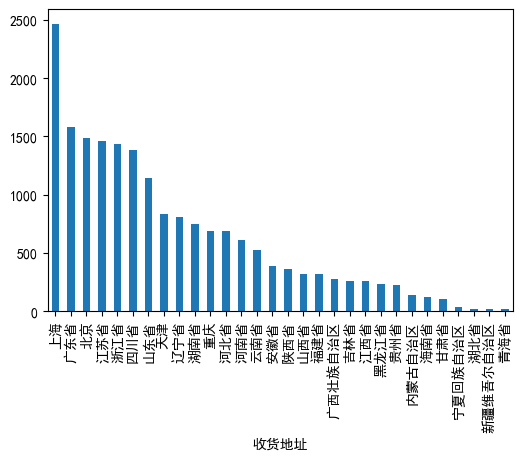

In [296]:
se_trans_map = df_trans.groupby('收货地址')['收货地址'].count().sort_values(ascending = False)
plt.figure(dpi = 100)
se_trans_map.plot(kind = 'bar')
# len(se_trans_map)

In [297]:
# 为了保持由于下面的地理分布图使用的省份名称一致，定义一个处理自治区的函数
def strip_region(iterable):
    result = []
    for i in iterable:
        if i.endswith('自治区'):
            if i == '内蒙古自治区':
                i = i[:3]
                result.append(i)
            else:
                result.append(i[:2])
        else:
            result.append(i)
    return result

In [298]:
# 处理自治区,
se_trans_map.index = strip_region(se_trans_map.index)

# 去掉末位‘省’字
se_trans_map.index = se_trans_map.index.str.strip('省')

In [299]:
import pyecharts.options as opts
from pyecharts.charts import Map

In [300]:
# 展示地理分布图
name = '订单数'

(
    Map()
    .add(
        series_name = name,
        data_pair= [list(i) for i in se_trans_map.items()])
    .set_global_opts(visualmap_opts=opts.VisualMapOpts(
        max_=max(se_trans_map)*0.6
    )
                    )
    .render_notebook()
)

## 五、结论  
1. 需要提高非活动期间用户的下单量，建议深入分析用户是否到达流失期，分析用户在平台中的生命周期时间，结合实际情况探索新类型的用户。  
2. 对付款时间超过10分钟以上的用户进行行为分析与用户调研，探索过长时间付款的原因，是否是由平台bug等问题产生的，可以添加自动订单付款push的功能。  
3. 通过按成交天数分析，在2月上半月，由于疫情等停工停产，物流快递停运等原因，订单量普遍较少，甚至少有10单。在下半月，随着复工复产，订单量开始上升，逐渐恢复。
2. 订单量主要分布在东部沿海较发达地区，而内陆偏远地区，即俗称的不包邮区以及疫情较重的湖北省的订单量相对较少。这与我国经济发展分布是有较大关系。
